<a href="https://colab.research.google.com/github/jbEmanuel/Machine_Learning_Course/blob/main/Breast_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projecto Final do Módulo de Apredizado de Máquina**

# **Leitura das Bibliotecas e outras Dependências**

In [189]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif 
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold, train_test_split, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier 
from sklearn.base import clone
from itertools import combinations 
from sklearn.metrics import plot_roc_curve 
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as skmetrics
import seaborn as sns
import xgboost as xgb
from sklearn import metrics
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_recall_curve, make_scorer, accuracy_score, recall_score, fbeta_score,precision_score, roc_auc_score, f1_score, make_scorer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC

# 1. Source

## Standard Scaler and Encoders

In [190]:
# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

#Standard Scaler 
def standard_scaler(X_train, X_test):
    stdc = StandardScaler()
    X_train_std = stdc.fit_transform(X_train)
    X_test_std = stdc.transform(X_test)
    return X_train_std, X_test_std


## Plots Functions

In [191]:
def plot_confusion_matrix(y_test, y_pred):    
    # get confusion matrix from sklearn
    cm = metrics.confusion_matrix(y_test, y_pred)
    # plot using matplotlib and seaborn
    plt.figure(figsize=(10, 10))
    cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0,
    as_cmap=True)
    sns.set(font_scale=2.5)
    sns.heatmap(cm, annot=True, cmap=cmap, cbar=False)

def plot_precision_recall_vs_threshold(y_train, y_scores):
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

## Feature Selection Classes and Functions

### Random Forrest Feature Selection

In [192]:
class RFFS():
    def __init__(self, X, y, col_names):
        self.X = X
        self.y = y
        self.col_names = col_names

#X_train,y_train,X_test,y_test = train_test_split(data,test_size=0.3)
    def plot_model(self, n_estimators, random_state = 1):
        model = RandomForestClassifier(n_estimators = n_estimators, random_state = random_state)
        # fit the model
        model.fit(self.X, self.y)
        importances = model.feature_importances_
        idxs = np.argsort(importances)
        plt.title('Feature Importances')
        plt.barh(range(len(idxs)), importances[idxs], align='center')
        plt.yticks(range(len(idxs)), [self.col_names[i] for i in idxs])
        plt.xlabel('Random Forest Feature Importance')
        plt.show()


### Sequential Backward Selection Method Implementation

In [193]:
class SBS():
    def __init__(self, estimator, k_features, scoring= accuracy_score, test_size = 0.25, random_state =1):
        self.scoring = scoring
        self.estimator = estimator
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test,y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim -1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self 

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score 


### ANOVA Feature Selection Implementation

In [194]:
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_classif, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# 2. Reading the Data and Exploratory Data Analysis

## 2.1 Data Vizualization

In [ ]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00451/dataR2.csv")
df.head(n=10)

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1
5,49,22.854458,92,3.226,0.732087,6.8317,13.679750,10.31760,530.410,1
6,89,22.700000,77,4.690,0.890787,6.9640,5.589865,12.93610,1256.083,1
7,76,23.800000,118,6.470,1.883201,4.3110,13.251320,5.10420,280.694,1
8,73,22.000000,97,3.350,0.801543,4.4700,10.358725,6.28445,136.855,1
9,75,23.000000,83,4.952,1.013839,17.1270,11.578990,7.09130,318.302,1


### 2.2.0 Exploratory Data Analysis using sweetviz library

Install sweetviz library for Exploratory Data Analysis

In [ ]:
pip install sweetviz

In [ ]:
# import sweetviz 
import sweetviz as sv

                                             |          | [  0%]   00:00 -> (? left)


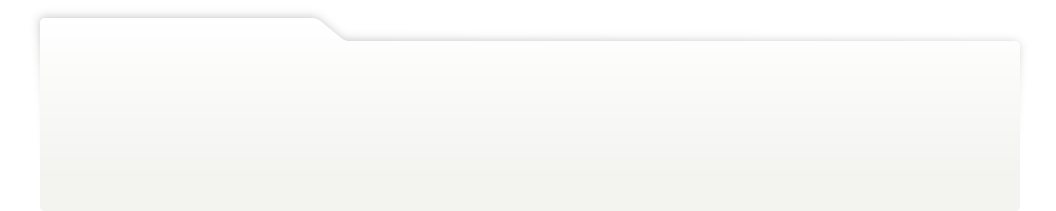
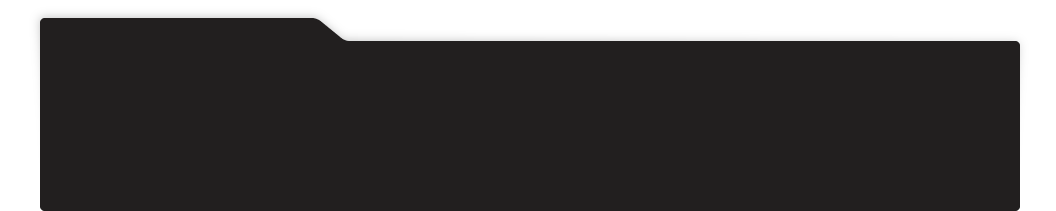
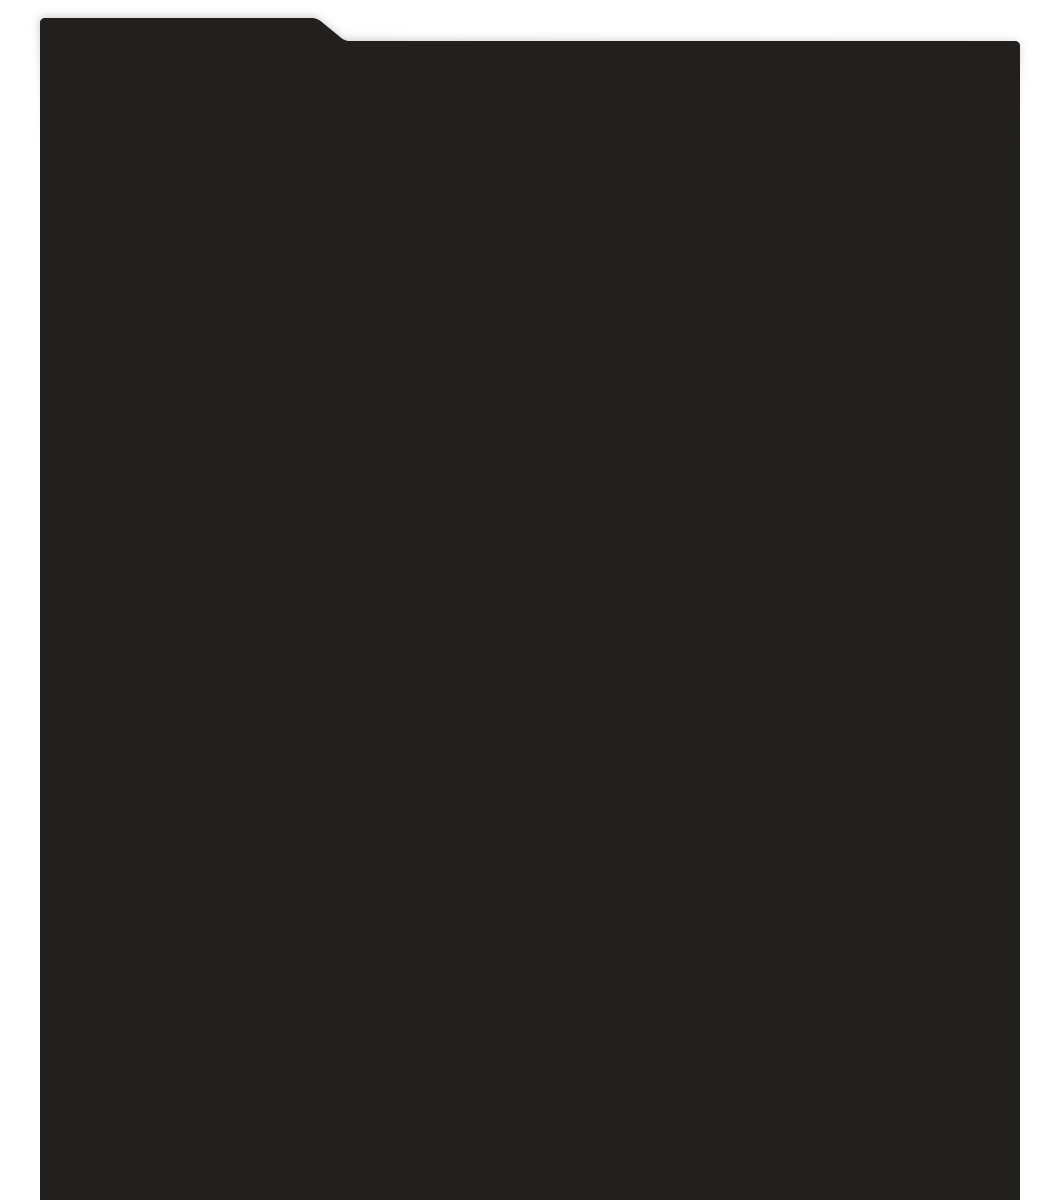
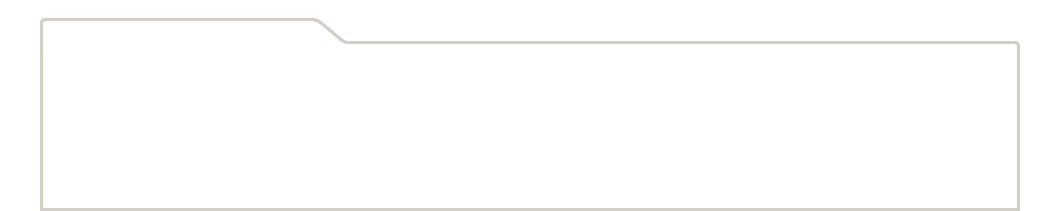
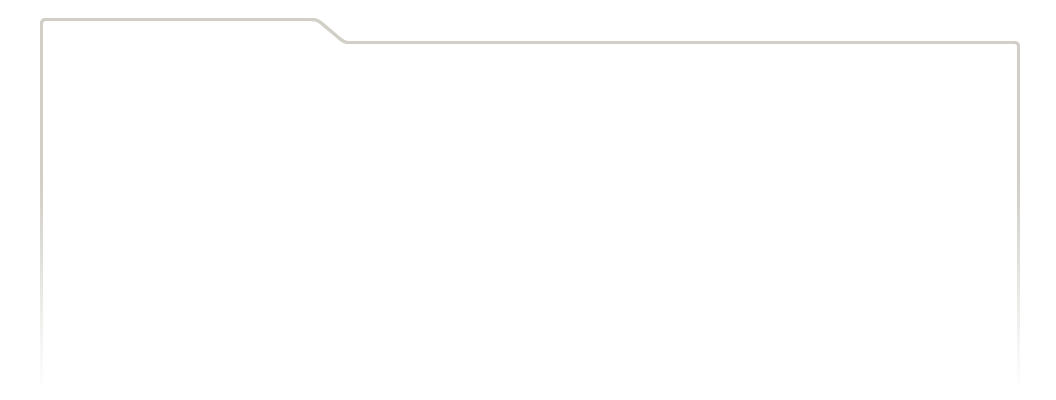
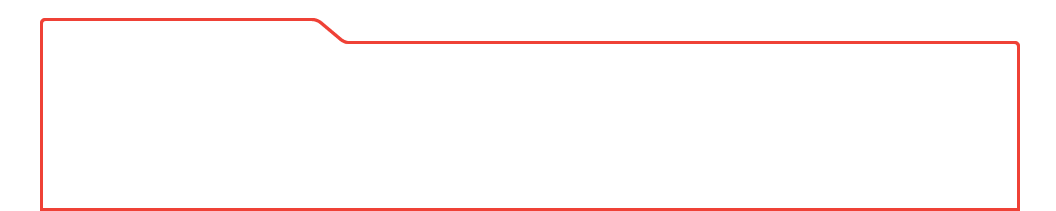
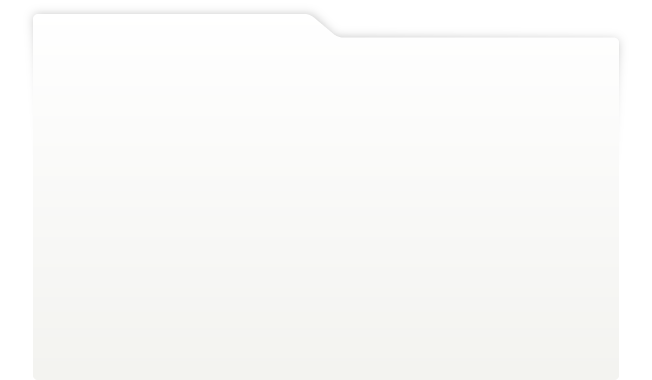
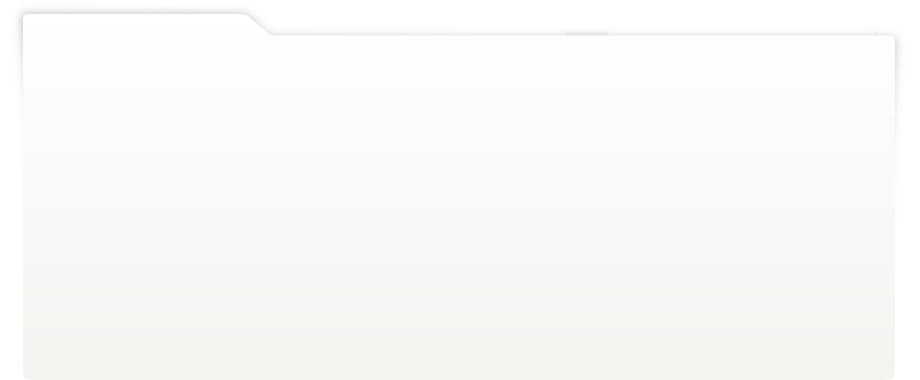
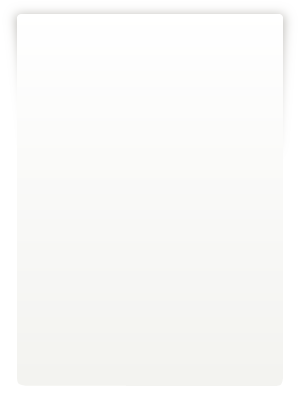
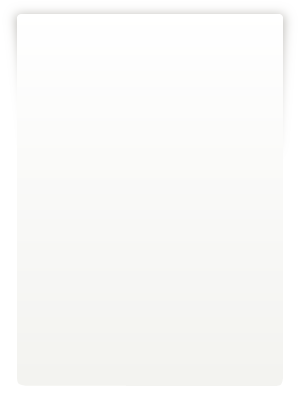
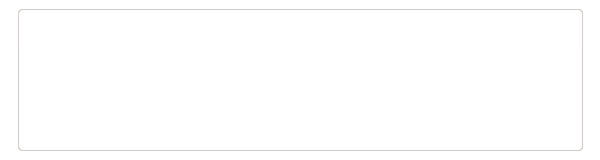
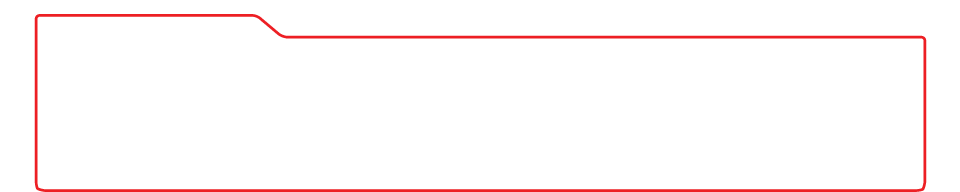
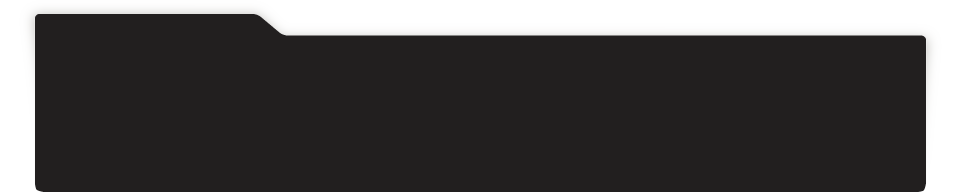
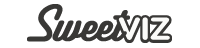
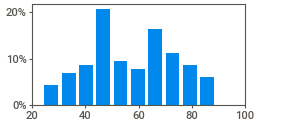
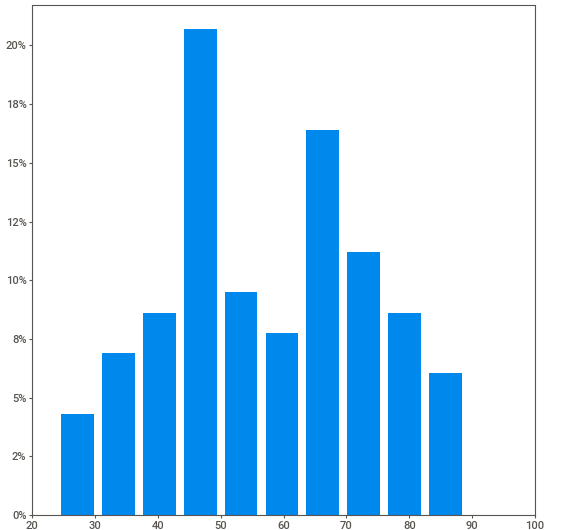
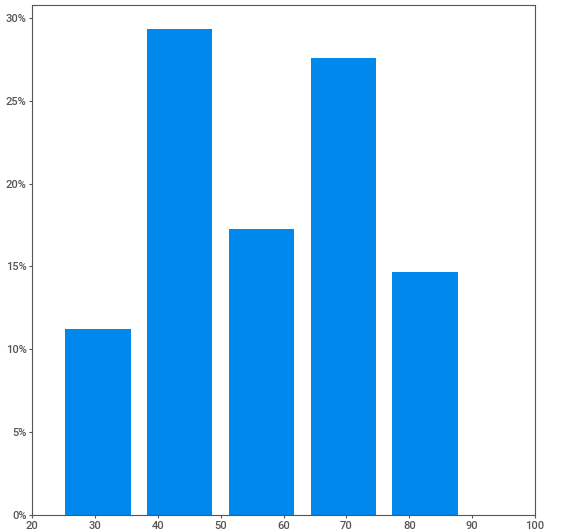
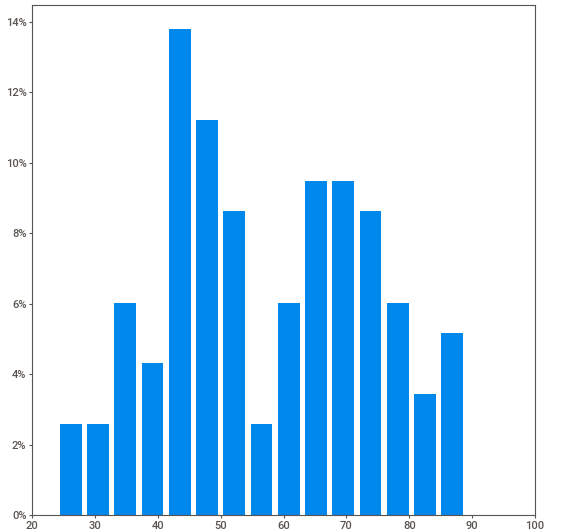
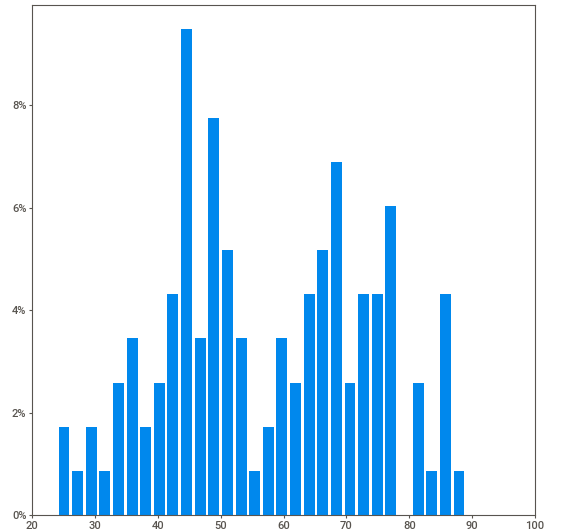
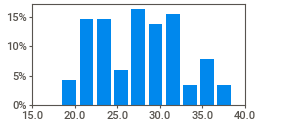
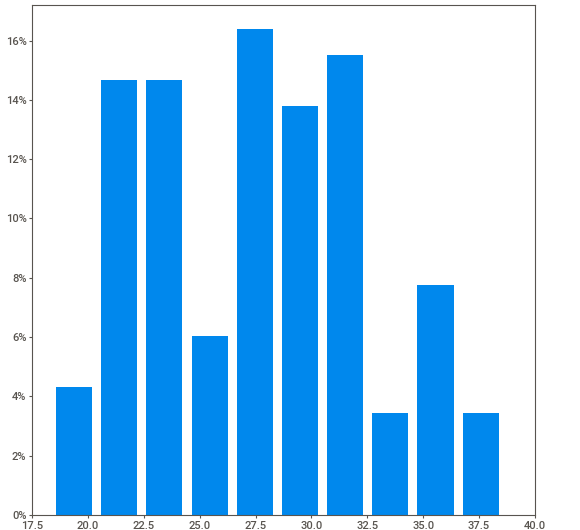
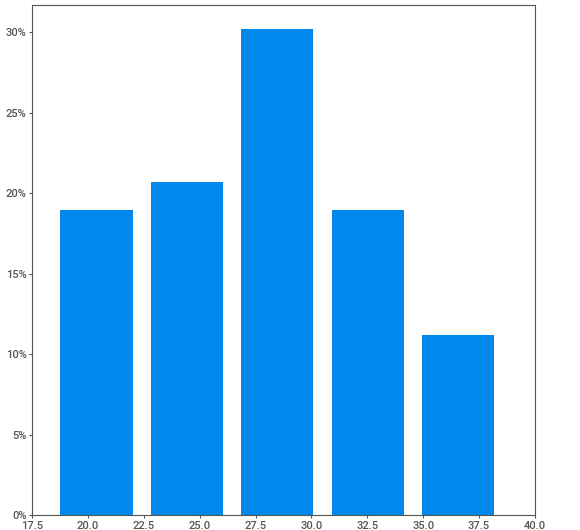
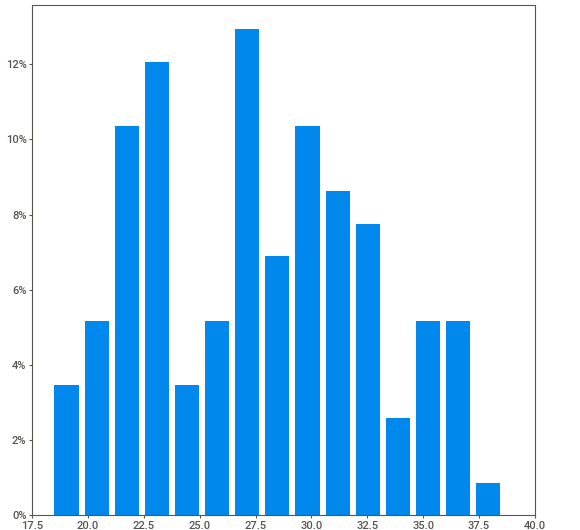
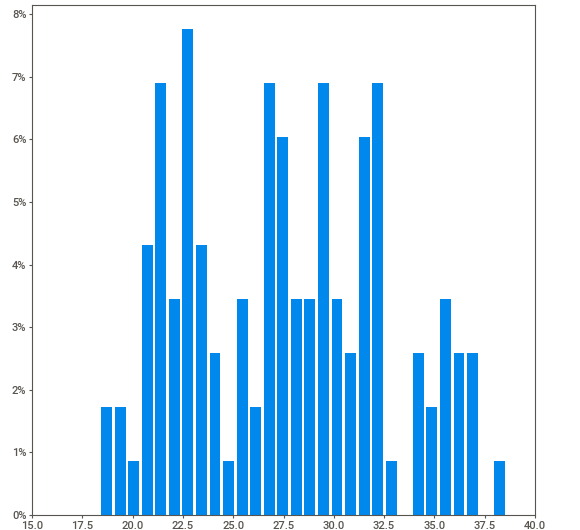
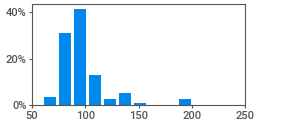
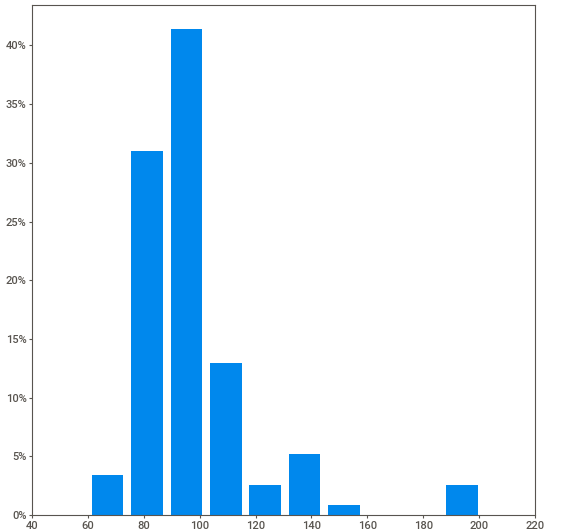
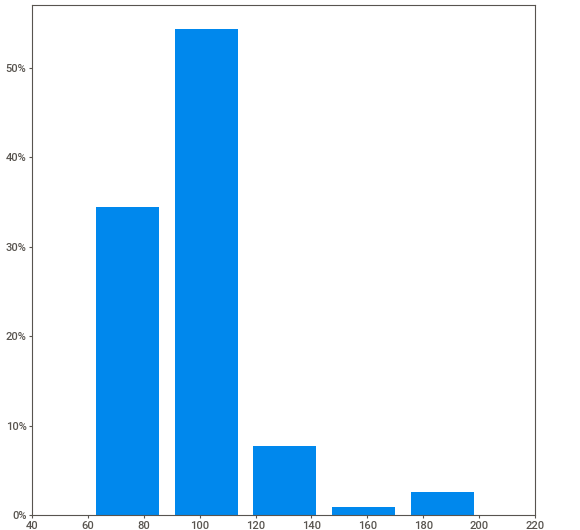
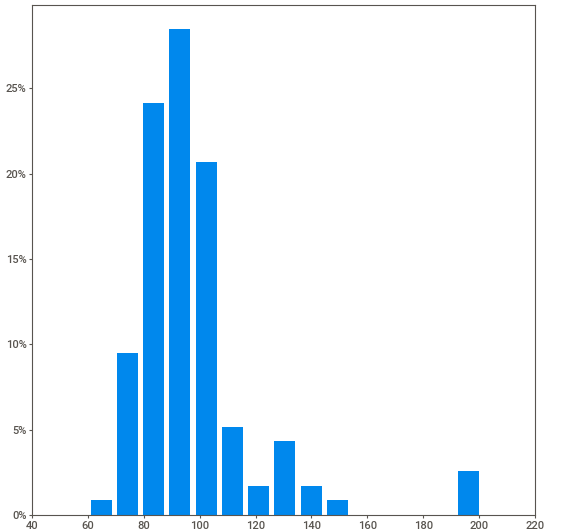
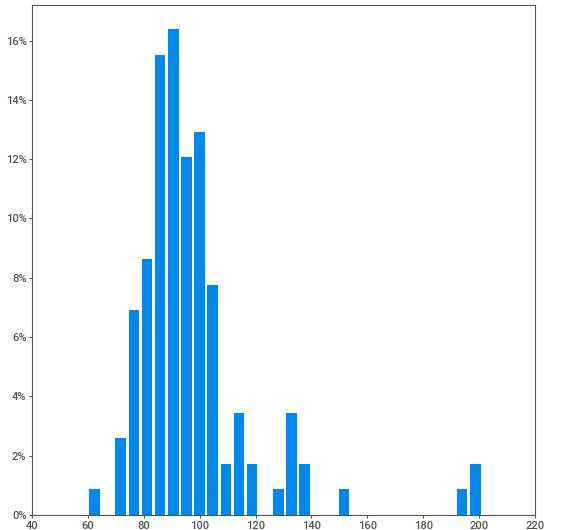
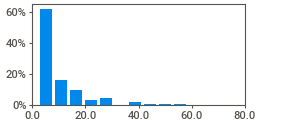
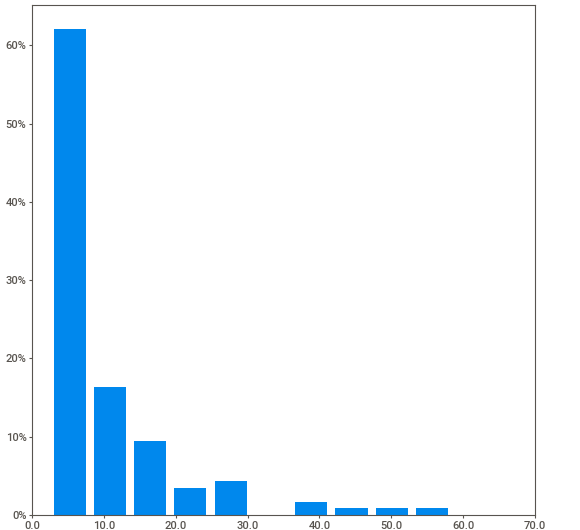
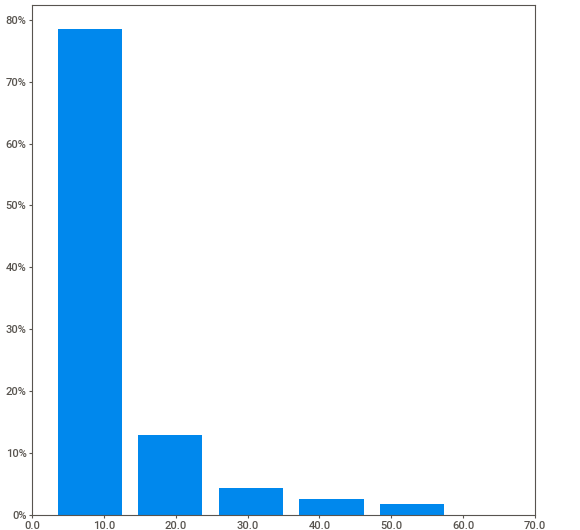
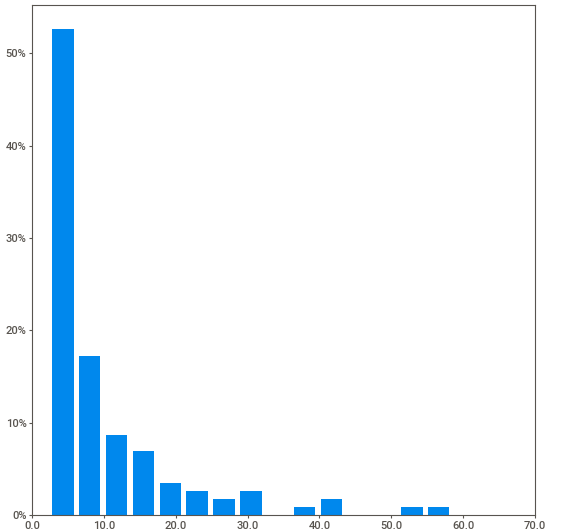
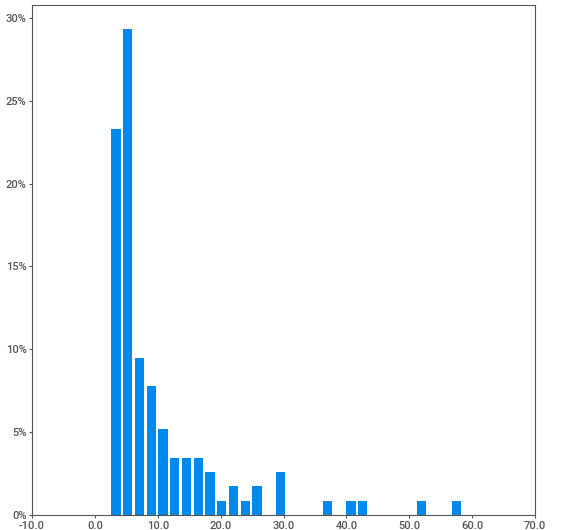
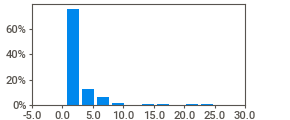
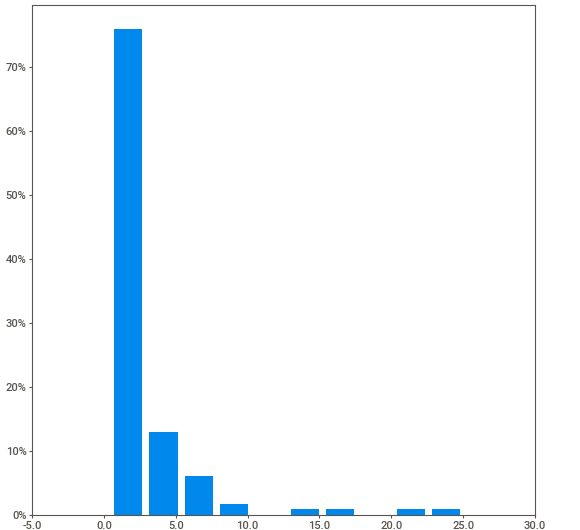
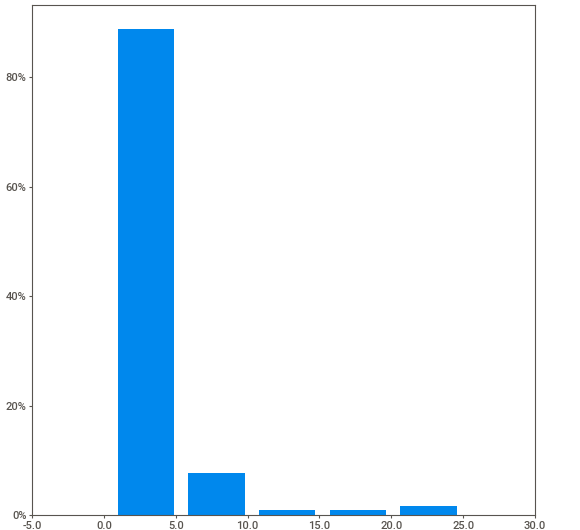
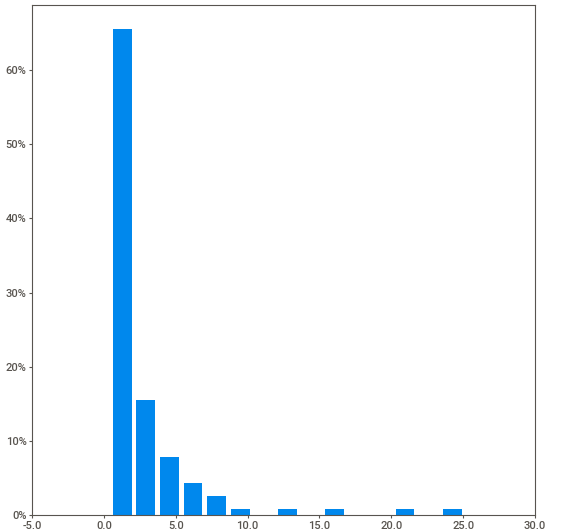
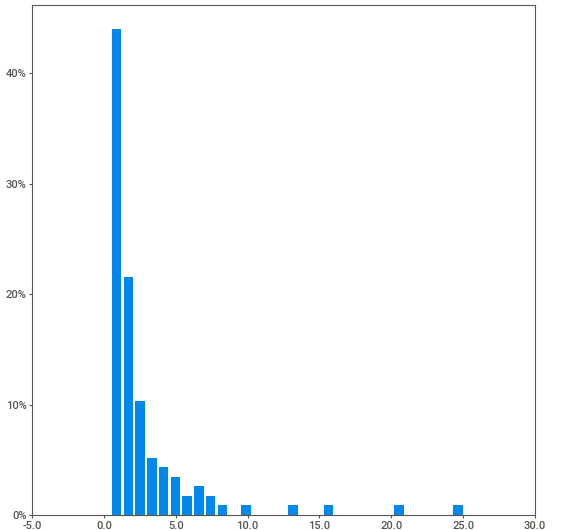
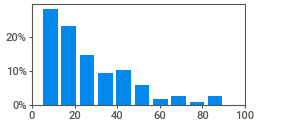
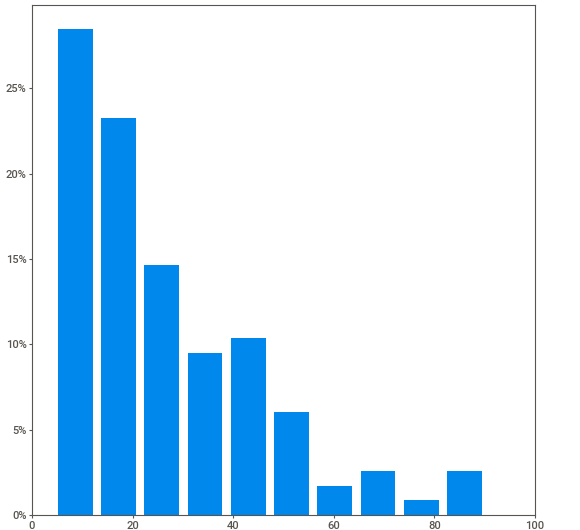
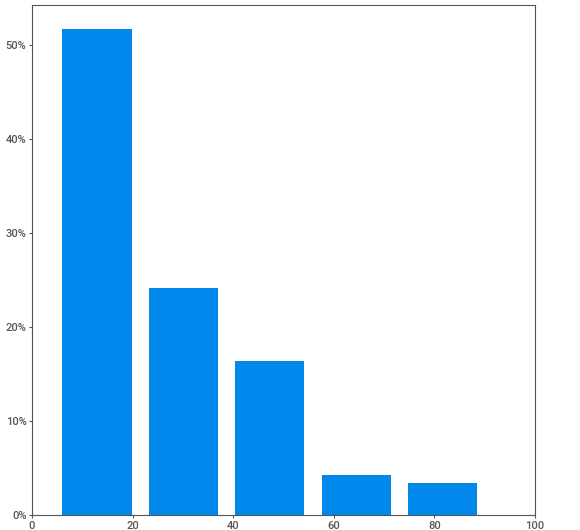
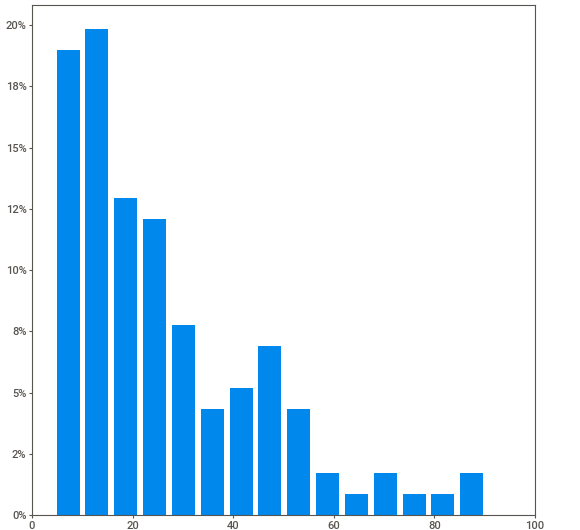
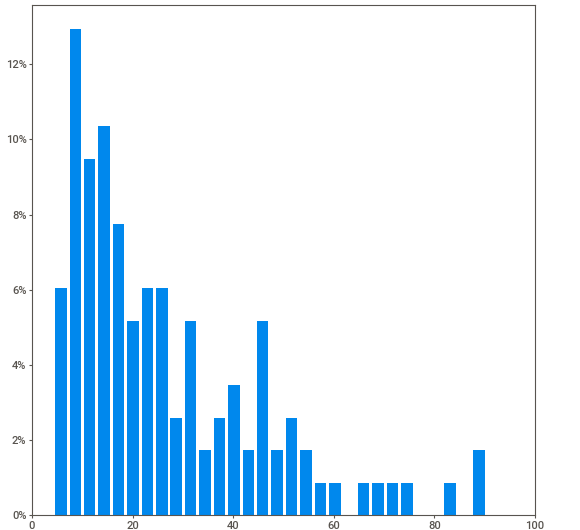
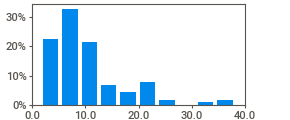
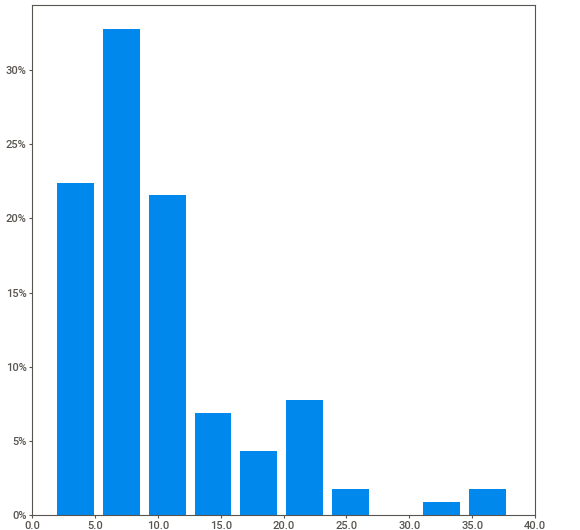
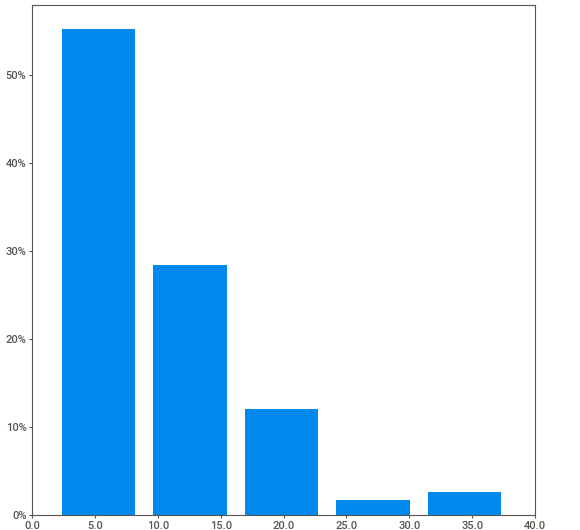
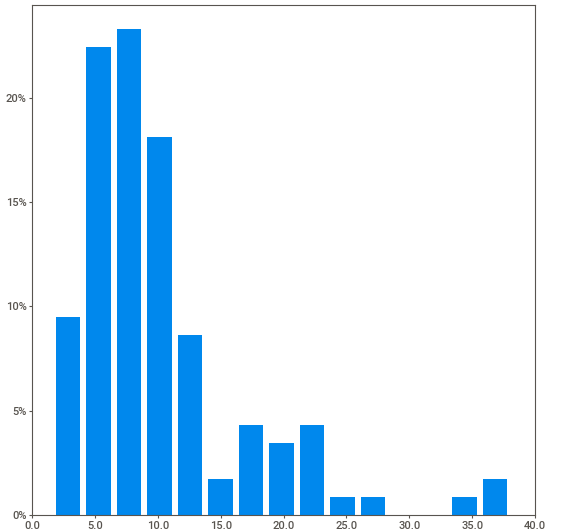
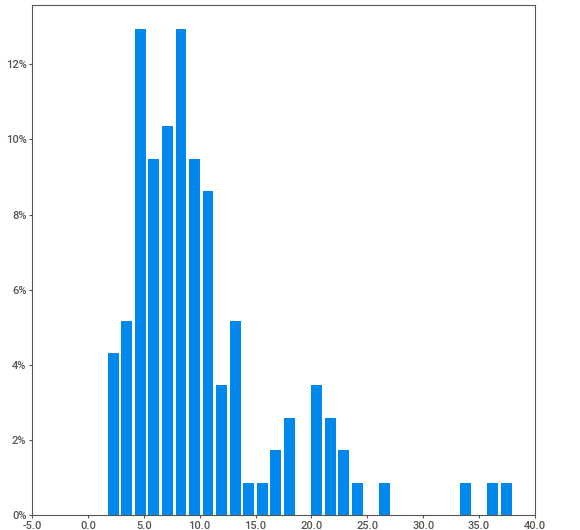
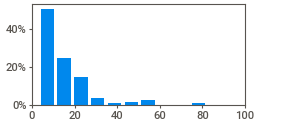
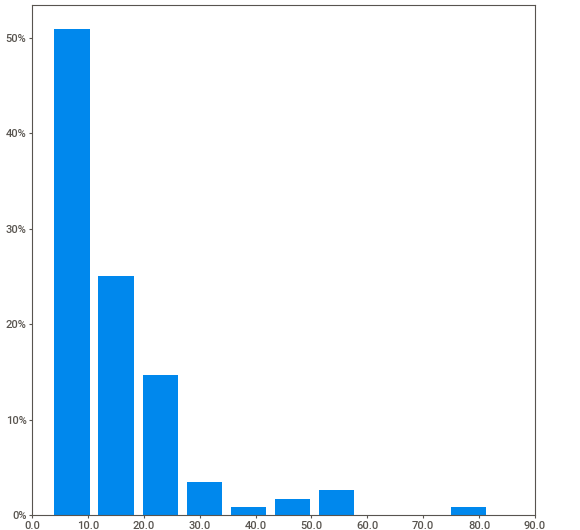
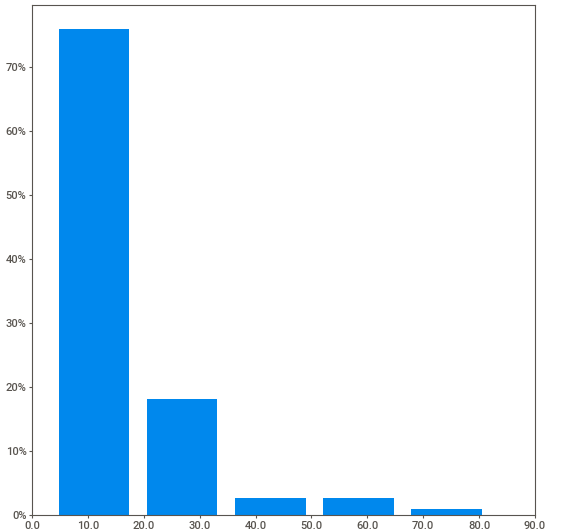
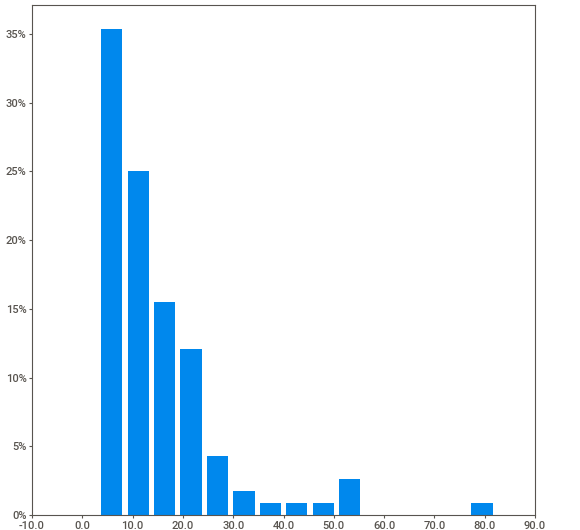
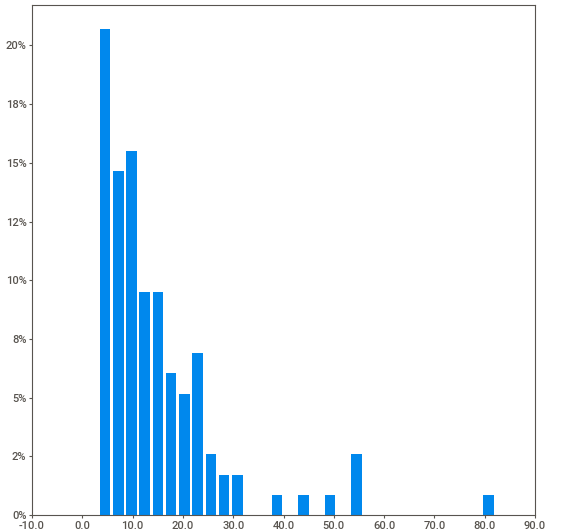
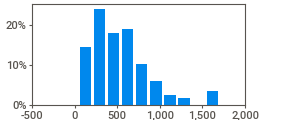
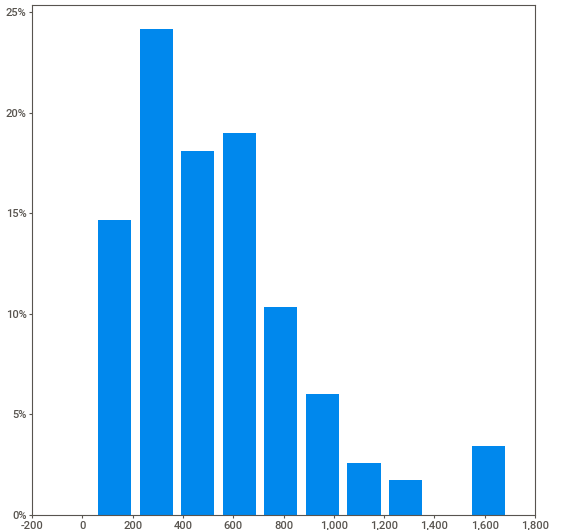
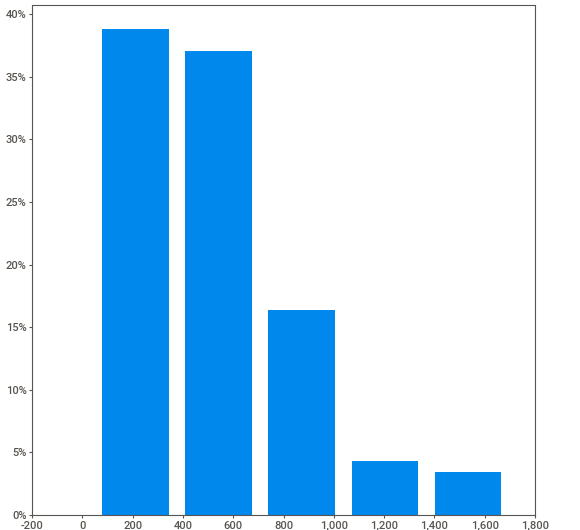
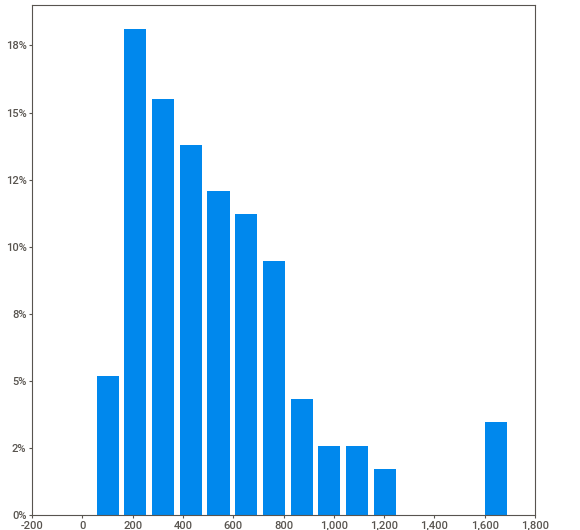
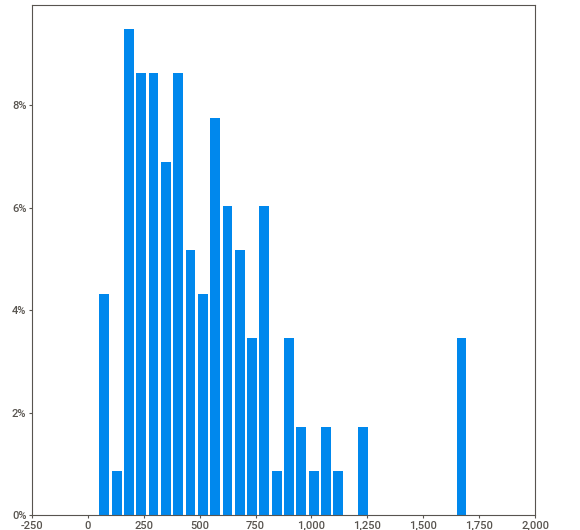
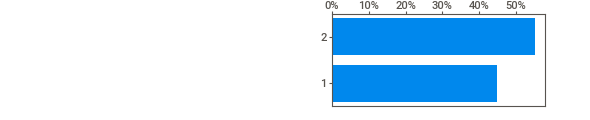
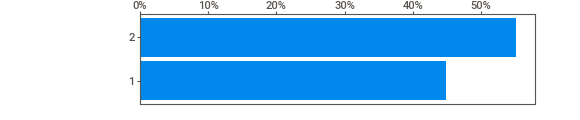
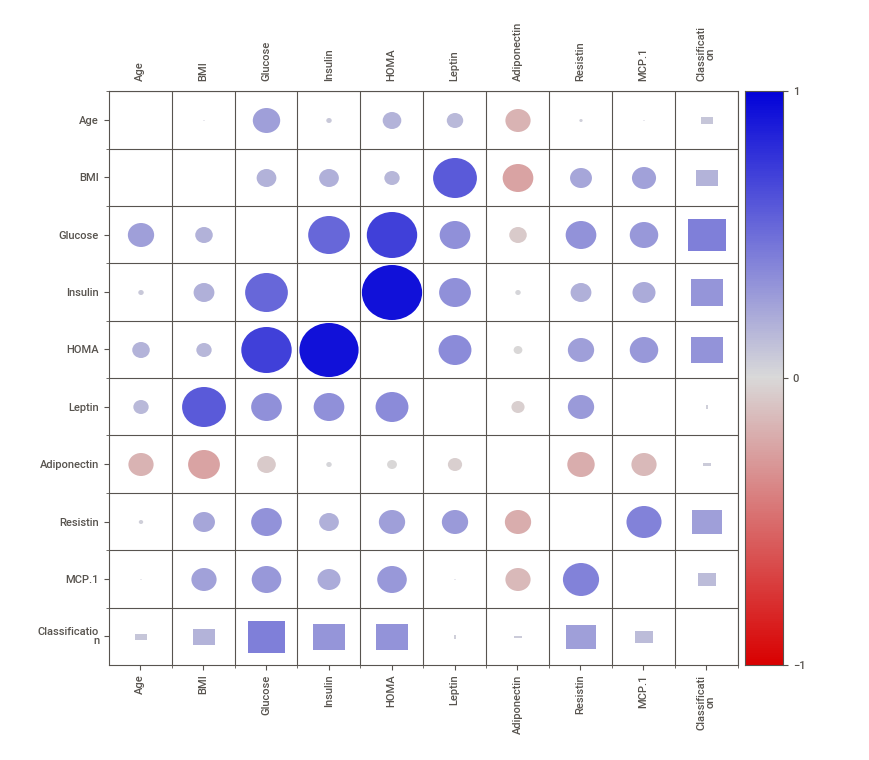
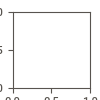

In [ ]:
# generate a report for each feature
my_report = sv.analyze(df)
my_report.show_notebook() # Default arguments will generate a notebook report

### 2.2.1 Change Classification Columns to Object and Binaryze the columns

In [ ]:
binary = {1:1, 2:0}
df.loc[:, "Classification"] = df.Classification.map(binary)
df['Classification'].astype('object')

0      1
1      1
2      1
3      1
4      1
      ..
111    0
112    0
113    0
114    0
115    0
Name: Classification, Length: 116, dtype: object

### 2.2.2 Separar a variável dependente das independentes

In [ ]:
colunas = df.drop(['Classification'], axis = 1).columns
X = df[colunas].values
y = df['Classification'].values

### 2.2.3 Create training and test data


In [ ]:
# Create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y, random_state = 42)

# Standardadize X_train and X_test data
X_train_std, X_test_std = standard_scaler(X_train, X_test)

# 3. Feature Selection

## 2.1 Random Forrest Feature Selection

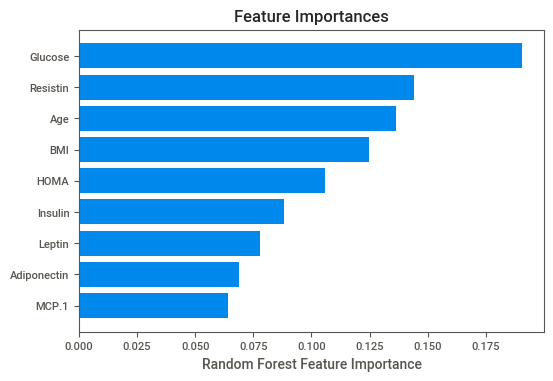

In [ ]:
# Plot features importance obtained using Random Forrest 
features_importance = RFFS(X, y, colunas)
features_importance.plot_model(500)

## 2.2 Create data with the best features obtained in 2.1

In [ ]:
# X_rf meaning X obtained from random forest feature selection
# Create X values with Age, Resistin, Glucose and BMI columns
X_rf = df[['Age', 'Resistin', 'Glucose','BMI']].values

# Create test and training datas
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size = 0.30, stratify = y, random_state = 42)

# Standardize X test and training data
X_train_std_rf, X_test_std_rf = standard_scaler(X_train_rf, X_test_rf)

## 2.2 Feature Selection Using ANOVA F-test

Age: 0.498187
BMI: 1.154242
Glucose: 13.544265
Insulin: 6.672621
HOMA: 7.194904
Leptin: 0.013566
Adiponectin: 0.040117
Resistin: 3.272043
MCP.1: 0.722664


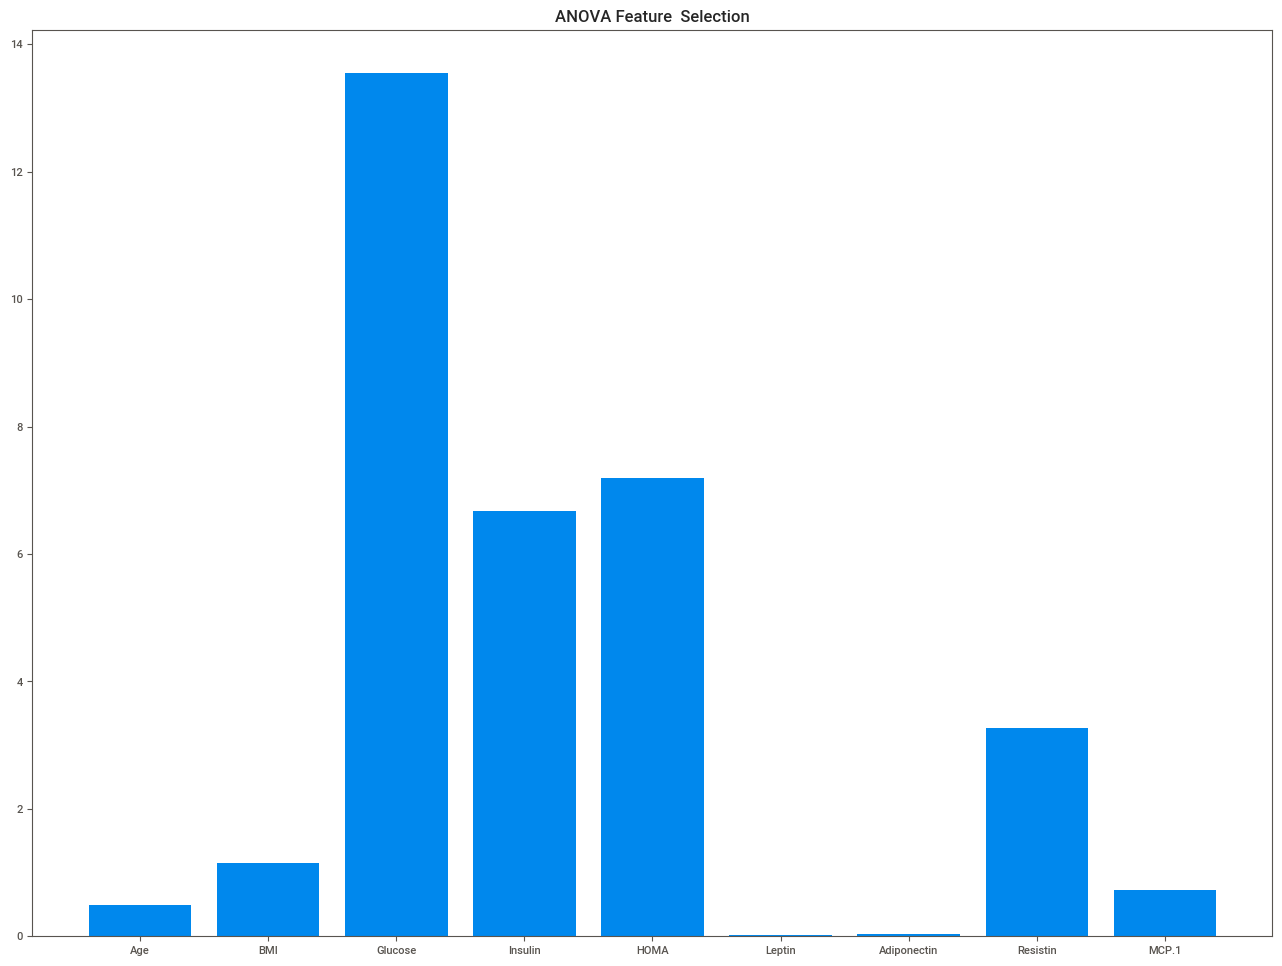

In [ ]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# what are scores for the features
for feature, i in zip(colunas,range(len(fs.scores_))):
	print(f'{feature}: %f' % (fs.scores_[i]))

# plot the scores
fig = plt.figure(figsize = (16, 12))
plt.bar([feature for feature in colunas], fs.scores_)
plt.title("ANOVA Feature  Selection")
plt.show()

## 2.3 Feature Selection using SBS

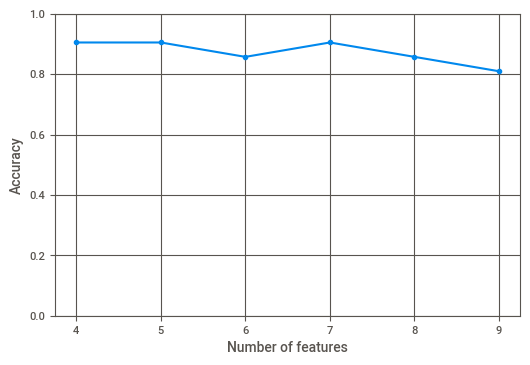

In [ ]:
rfc = RandomForestClassifier(n_estimators = 500, random_state = 1)
sbs = SBS(rfc, k_features= 4)
sbs.fit(X_train, y_train)
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [ ]:
k5 = list(sbs.subsets_[5])
print(df.columns[1:][k5])

Index(['BMI', 'Glucose', 'Insulin', 'MCP.1'], dtype='object')


# 4. Classification Models Application

## 4.1 KNN Neighboors Model fitting with K-cross Validation and GridSearchCV

In [ ]:
# First we instatiate the knn model
knn = KNeighborsClassifier()

In [ ]:
#create a dictionary with all hyperparameters and the respectives values
param_grid = {"n_neighbors": np.arange(1, 25)}

# create dictionary with all metrics
my_scores = {'accuracy': make_scorer(accuracy_score), 
             'recall': make_scorer(recall_score),
             'precision': make_scorer(precision_score),
             'f1': make_scorer(fbeta_score, beta = 1),
             'roc_auc': make_scorer(roc_auc_score)}

### 3.2.1 KNN Using all features

In [ ]:
knn_gs = GridSearchCV(estimator= knn, param_grid=param_grid, scoring= my_scores, cv = 10, refit= 'roc_auc', n_jobs=-1)
knn_gs.fit(X_train_std, y_train)
#pd.DataFrame(clf_1.cv_results_)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score=False,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(fbeta_score, beta=1),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)},
             verbose=0)

In [ ]:
print('My best model is: ',knn_gs.best_estimator_)
print('-------------------------------')
print('My best score is:', knn_gs.best_score_)

My best model is:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
-------------------------------
My best score is: 0.7075


In [ ]:
final_model = knn_gs.best_estimator_
y_predict = final_model.predict(X_test_std)
final_metric = skmetrics.roc_auc_score (y_predict, y_test)
print(final_metric)

0.7728758169934641


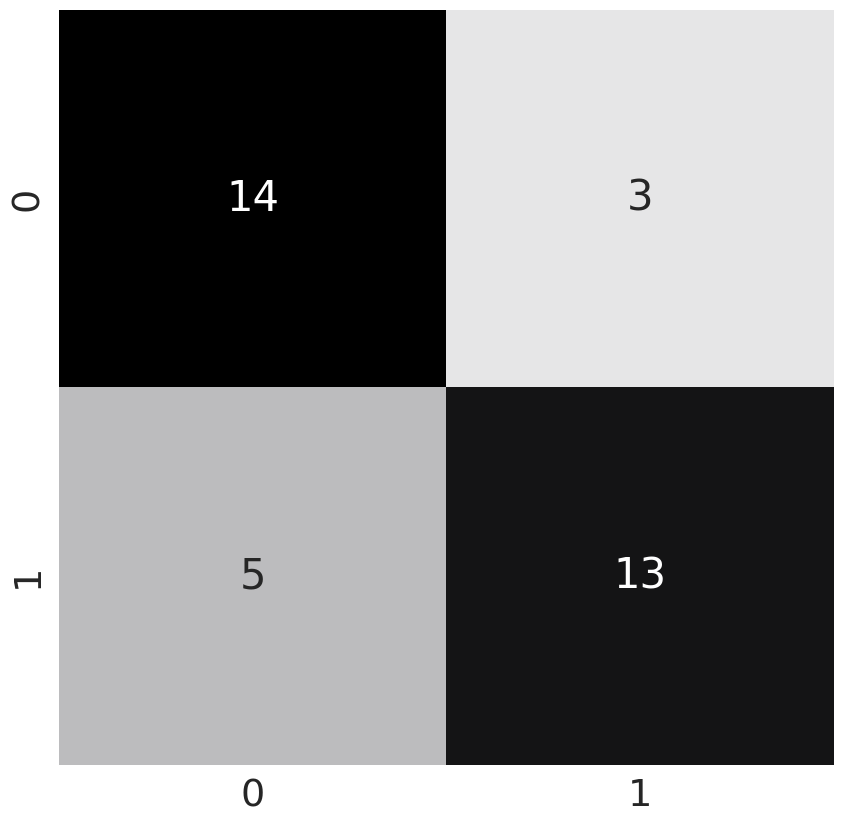

In [ ]:
# Plot confusion matrix 
conf_matrix_knn_gs = plot_confusion_matrix(y_predict, y_test)

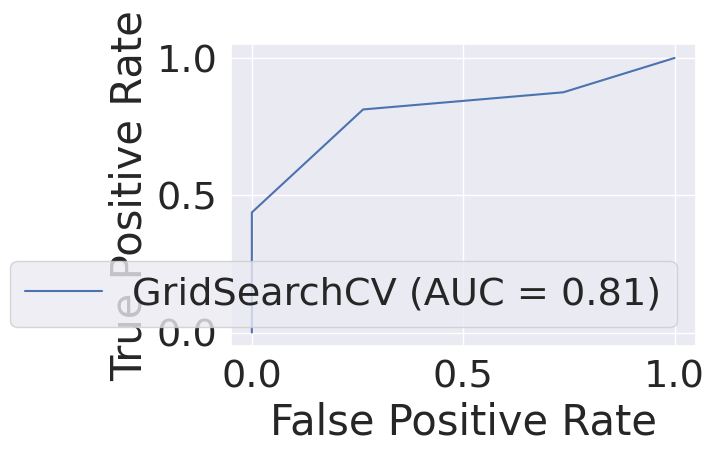

In [ ]:
#plot roc curve
plot_roc_curve(knn_gs, X_test_std, y_test)

### 3.2.2 KNN Using Features Resistin, glucose, age and BMI

In [ ]:
# X_train_std_rf, X_test_std_rf 

knn_gs_rf = GridSearchCV(estimator= knn, param_grid=param_grid, scoring= my_scores, cv = 10, refit= 'roc_auc', n_jobs=-1)
knn_gs_rf.fit(X_train_rf, y_train_rf)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score=False,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(fbeta_score, beta=1),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)},
             verbose=0)

In [ ]:
print('My best model is: ',knn_gs_rf.best_estimator_)
print('-------------------------------')
print('My best score is:',knn_gs_rf.best_score_)

My best model is:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
-------------------------------
My best score is: 0.575


In [ ]:
final_model_knn_rf = knn_gs_rf.best_estimator_
y_predict_knn_rf = final_model_knn_rf.predict(X_test_std_rf)
final_metric_knn_rf = skmetrics.f1_score (y_predict_knn_rf, y_test)
print(final_metric_knn_rf)

0.6274509803921569


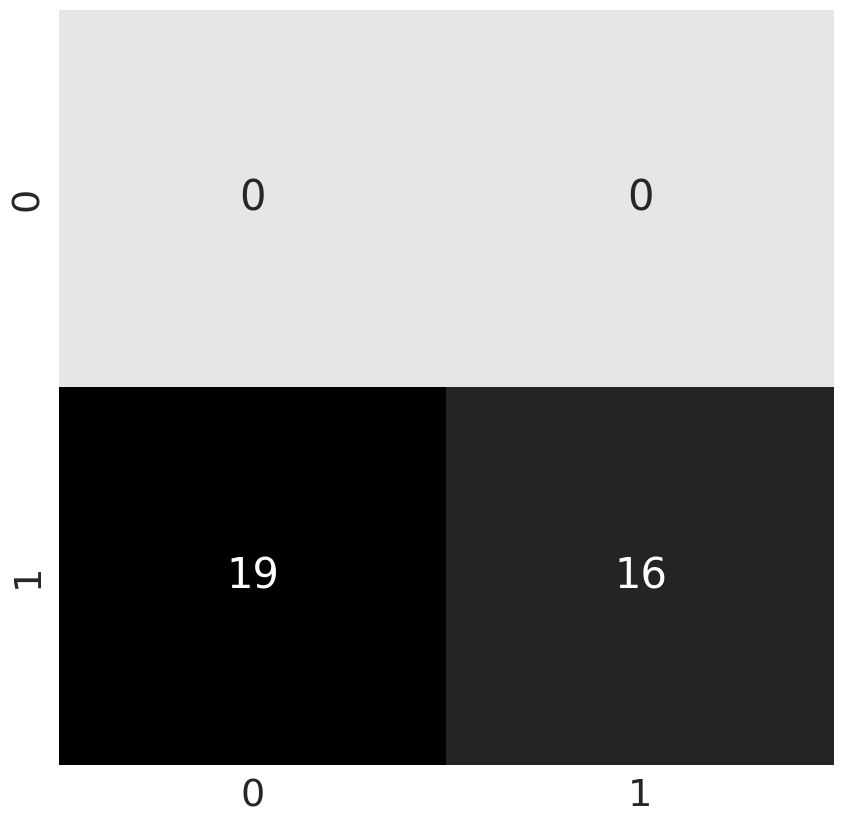

In [ ]:
# Plot confusion matrix 
conf_matrix_knn_gs_rf = plot_confusion_matrix(y_predict_knn_rf, y_test_rf)

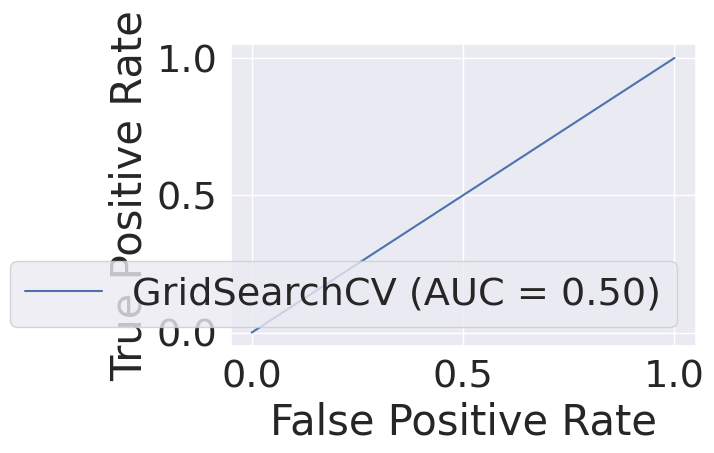

In [ ]:
#plot roc curve
plot_roc_curve(knn_gs_rf, X_test_std_rf, y_test_rf)

## 4.2 Logistic Regression with GridsearchCV

### 4.2.1 Logistic Regression with all features

In [ ]:
#Instantiate the model
lr = LogisticRegression()

In [ ]:

#create a dictionary with all hyperparameters
param_grid = {"C": np.array([1.0, 0.1, 0.001]), "penalty":["l1","l2"], "solver": ["liblinear","saga"]}

# create dictionary with all metrics
my_scores = {'accuracy': make_scorer(accuracy_score), 
             'recall': make_scorer(recall_score),
             'precision': make_scorer(precision_score),
             'f1': make_scorer(fbeta_score, beta = 1),
             'roc_auc': make_scorer(roc_auc_score)}

In [ ]:
#use gridsearch to find the best model

lr_gs = GridSearchCV(lr, param_grid, scoring= my_scores, cv = 10, refit= 'roc_auc')
#fit model to data
lr_gs.fit(X_train_std, y_train)

In [ ]:
print('My best model is: ',lr_gs.best_estimator_)
print('-------------------------------')
print('My best score is:', lr_gs.best_score_)

My best model is:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
-------------------------------
My best score is: 0.6950000000000001


In [ ]:
final_model_lr = lr_gs.best_estimator_
y_predict_lr = final_model_lr.predict(X_test_std)
final_metric_lr = skmetrics.roc_auc_score(y_predict_lr, y_test)
print(final_metric_lr)

0.7483552631578947


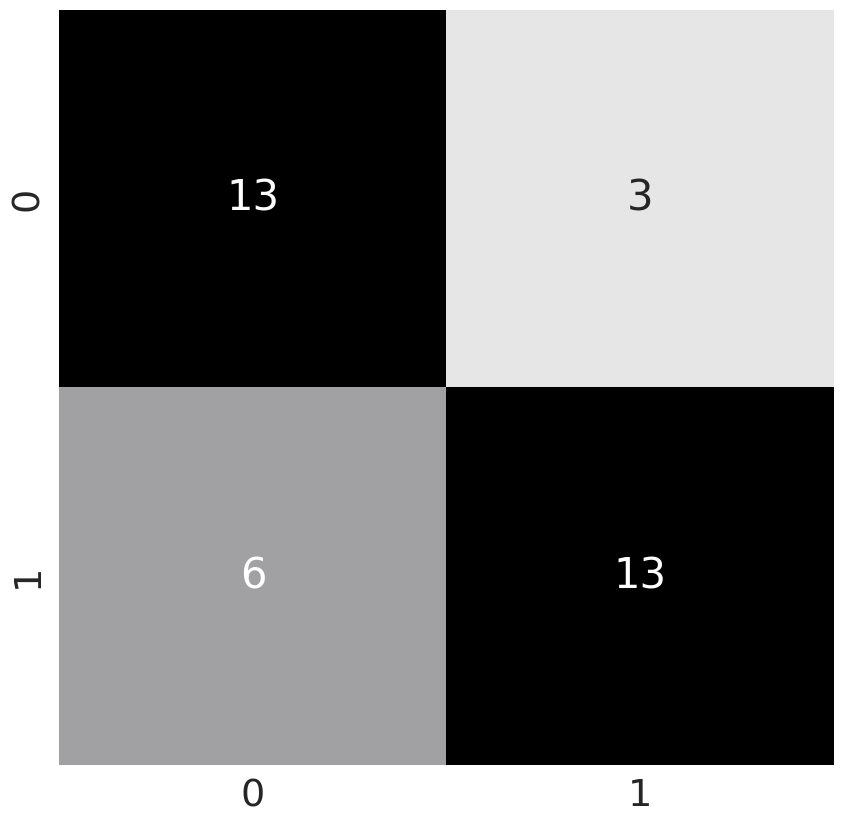

In [ ]:
# plot confusion matrix
conf_matrix_lr = plot_confusion_matrix(y_predict_lr, y_test)

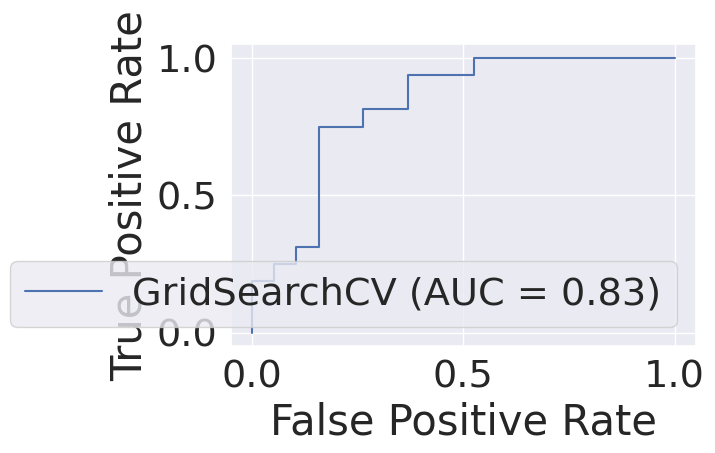

In [ ]:
# plot roc curve
plot_roc_curve(lr_gs, X_test_std, y_test)

### 4.2.2 Logistic Regression with Resistin, glucose, age and BMI

In [ ]:
param_grid_rf = {"C": np.array([1.0, 0.1, 0.001]), "solver": ["liblinear","saga"]}

In [ ]:
#use gridsearch to find the best model

lr_gs_rf = GridSearchCV(lr, param_grid_rf, scoring= my_scores, cv = 10, refit= 'roc_auc')
#fit model to data
lr_gs_rf.fit(X_train_std_rf, y_train_rf)

In [ ]:
print('My best model is: ',lr_gs_rf.best_estimator_)
print('-------------------------------')
print('My best score is:', lr_gs_rf.best_score_)

My best model is:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
-------------------------------
My best score is: 0.6883333333333332


In [ ]:
final_model_lr_rf = lr_gs_rf.best_estimator_
y_p_lr_rf = final_model_lr_rf.predict(X_test_std_rf)
final_metric_lr_rf = skmetrics.f1_score(y_p_lr_rf, y_test_rf)
print(final_metric_lr_rf)

0.7647058823529411


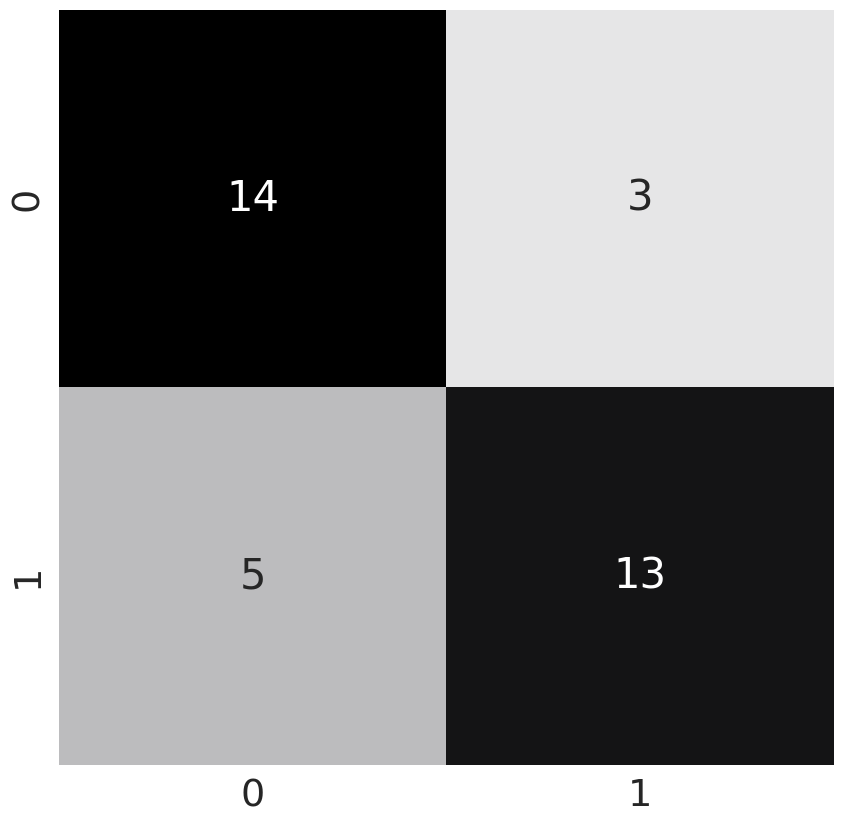

In [ ]:
conf_matrix_lr = plot_confusion_matrix(y_p_lr_rf, y_test_rf)

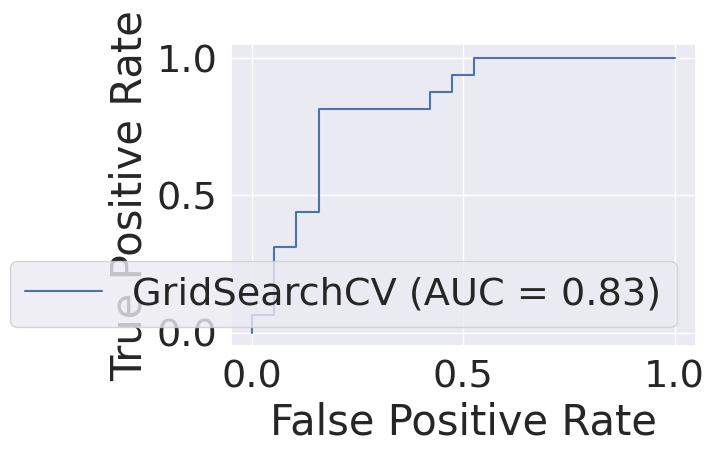

In [ ]:
# plot roc curve
plot_roc_curve(lr_gs_rf, X_test_std_rf, y_test_rf)

## 4.3 Decision Trees

### 4.3.1 Decision Trees with GridSearch CV

In [ ]:
# instantiate the model
dtr = DecisionTreeClassifier()

In [ ]:
#create a dictionary with all hyperparameters and the respectives values
param_grid = {'criterion': ['gini','entropy'],
'max_depth': np.arange(1,20),
'max_features': np.arange(3,9)}

In [ ]:
dctr_gs = GridSearchCV(estimator= dtr, param_grid=param_grid, scoring= my_scores, cv = 10, refit= 'roc_auc')
dctr_gs.fit(X_train_std, y_train)

In [ ]:
print('My best model is: ',dctr_gs.best_estimator_)
print('-------------------------------')
print('My best score is:',dctr_gs.best_score_)

My best model is:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
-------------------------------
My best score is: 0.7725


In [ ]:
final_model_dctr = dctr_gs.best_estimator_
y_predict_dctr = final_model_dctr.predict(X_test_std)
final_metric_dctr = skmetrics.roc_auc_score (y_predict_dctr, y_test)
print(final_metric_dctr)

0.5970394736842105


In [ ]:
# Apply the model
dt = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
dt.fit(X_train_std, y_train)
y_pred = dt.predict(X_test_std)
score = skmetrics.accuracy_score (y_pred, y_test)
#score_1 = skmetrics.roc_auc_score (y_pred, y_test)
print(score)

0.6857142857142857


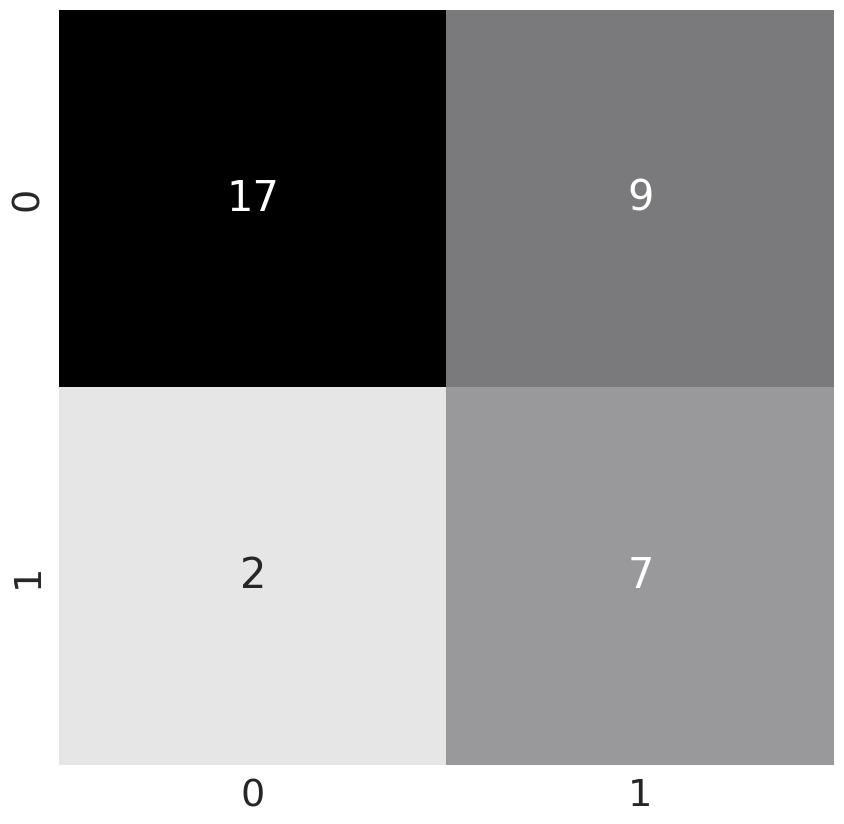

In [ ]:
# plot confusion matrix
conf_matrix_dct_gs = plot_confusion_matrix(y_pred, y_test)

## 4.4 SVM

### 4.4.1 SVM with GridSearch Cross-Validation with all features

In [ ]:
# Instantiate the Model
svc = SVC(random_state=1)

In [ ]:

param_range = np.array([0.001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0])
param_grid = [{'C': param_range, 'kernel': ['linear']}, 
              {'C': param_range, 'gamma': param_range, 'kernel': ['rbf']}]

svm_gs = GridSearchCV(estimator= svc, param_grid=param_grid, scoring= my_scores, cv = 10, refit= 'roc_auc', n_jobs=-1)
svm_gs = svm_gs.fit(X_train_std, y_train)
print(svm_gs.best_params_)
print(svm_gs.best_score_) 

{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.7416666666666667


In [ ]:
clf = svm_gs.best_estimator_
y_pred_svm = clf.predict(X_test_std)
final_score = skmetrics.roc_auc_score(y_pred_svm, y_test)
print(final_score)

0.7619047619047619


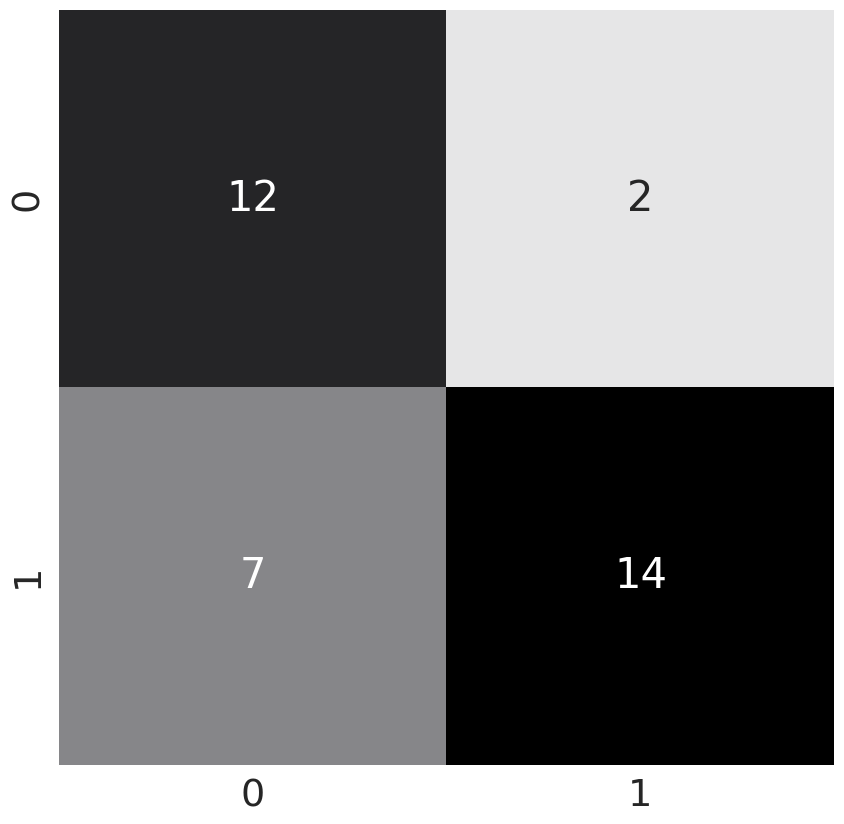

In [ ]:
svm_conf_matrix = plot_confusion_matrix(y_pred_svm, y_test)

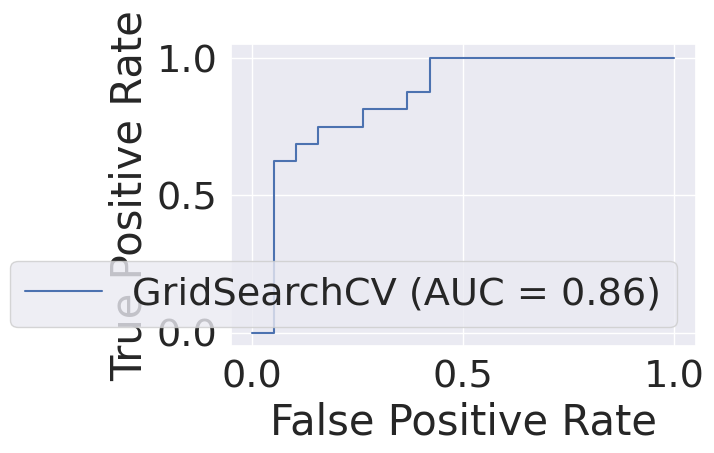

In [ ]:
#plot roc curve
plot_roc_curve(svm_gs, X_test_std, y_test)

### 4.4.2 SVM using Resistin, glucose,  age and BMI

In [ ]:
svm_gs_rf = GridSearchCV(estimator= svc, param_grid=param_grid, scoring= my_scores, cv = 10, refit= 'roc_auc', n_jobs=-1)
svm_gs_rf = svm_gs_rf.fit(X_train_std_rf, y_train_rf)
print(svm_gs_rf.best_params_)
print(svm_gs_rf.best_score_) 

{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.7416666666666667


In [ ]:
clf_rf = svm_gs_rf.best_estimator_
y_pred_svm_rf = clf_rf.predict(X_test_std_rf)
final_score_rf = skmetrics.roc_auc_score(y_pred_svm_rf, y_test_rf)
print(final_score_rf)

0.7619047619047619


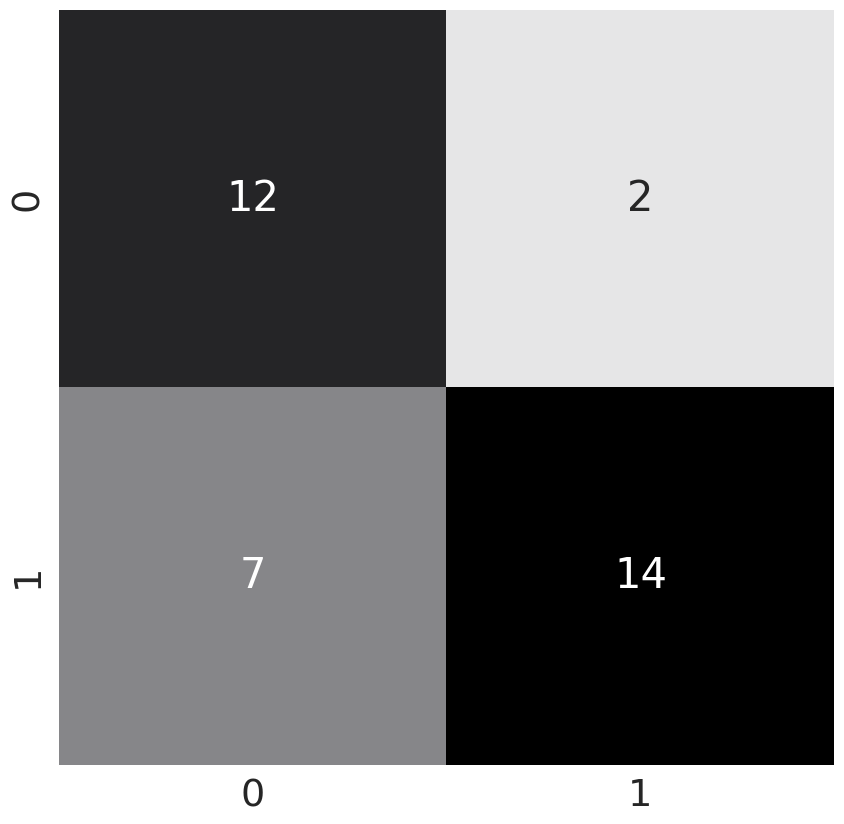

In [ ]:
svm_conf_matrix_rf = plot_confusion_matrix(y_pred_svm_rf, y_test_rf)

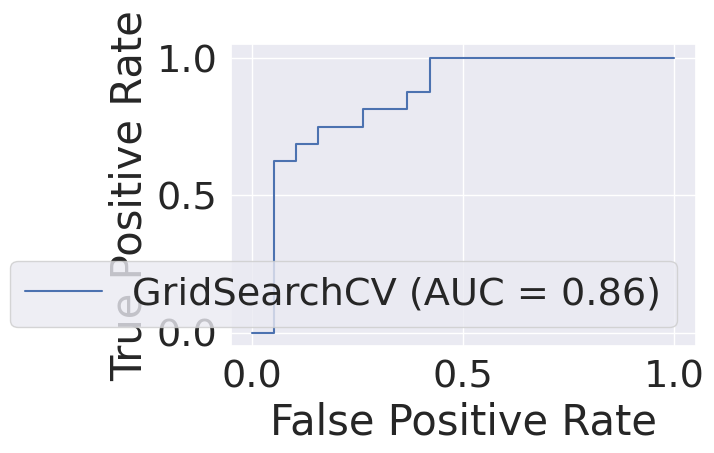

In [ ]:
#plot roc curve
plot_roc_curve(svm_gs_rf, X_test_std_rf, y_test_rf)

## 4.5 XGBoost with GridSearch

### 4.5.1 XGBoost


In [ ]:
# Instantiate the model
xgb_model = xgb.XGBClassifier()


In [ ]:
param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate':[0.0001, 0.001, 0.01, 0.1], #so called `eta` value
              'max_depth': np.arange(2,20),
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [1000]} #number of trees, change it to 1000 for better results

In [ ]:
xgb_gs = GridSearchCV(estimator= xgb_model, param_grid=param_grid, scoring= my_scores, cv = 10, refit= 'accuracy', n_jobs=-1)
xgb_gs.fit(X_train_std,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.01, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=1000, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_po...
                         'n_estimators': [1000], 'nthread': [4],
                         'objective': ['binary:logistic'], 'silent': [1],
                         'subsample': [0.8]},
             pre_dispatch='2*n_jobs', refit='accuracy',
             return_train_score=False,
             scoring={'accuracy': mak

In [ ]:
print('My best model is: ',xgb_gs.best_estimator_)
print('-------------------------------')
print('My best score is:',xgb_gs.best_score_)

My best model is:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=1, subsample=0.8, verbosity=1)
-------------------------------
My best score is: 0.8041666666666666


In [ ]:
final_model_xgb = xgb_gs.best_estimator_
y_predict_xgb = final_model_xgb.predict(X_test_std)
final_metric_xgb = skmetrics.roc_auc_score (y_predict_xgb, y_test)
print(final_metric_xgb)

0.7697368421052632


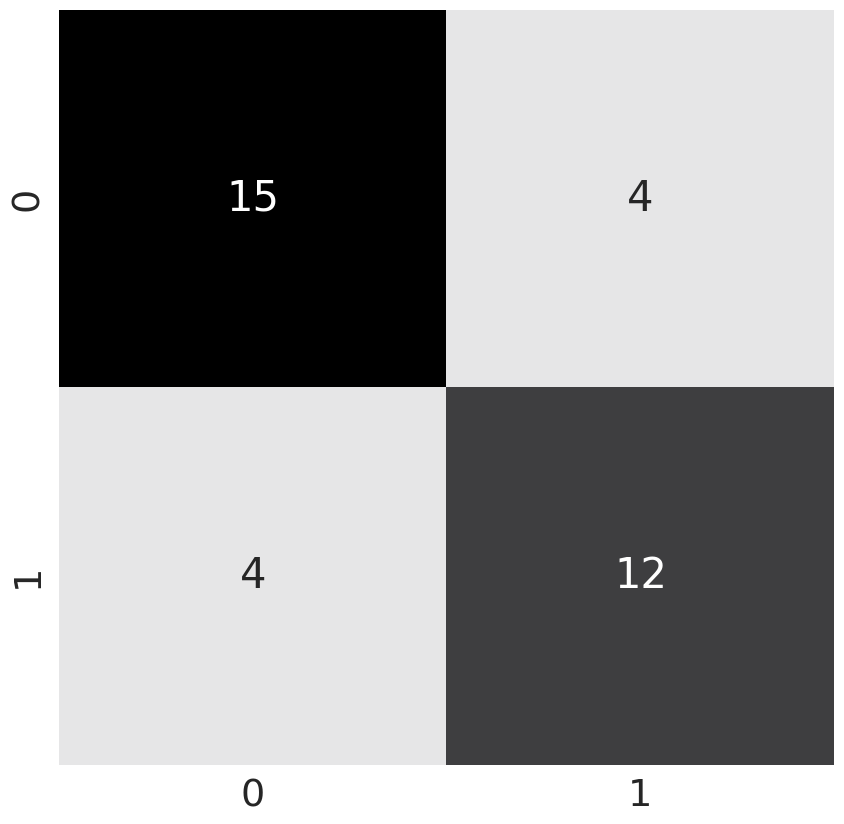

In [ ]:
xgb_conf_matrix = plot_confusion_matrix(y_predict_xgb, y_test)

In [ ]:
# Run the obtained model
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=1, subsample=0.8, verbosity=1)
xgb_model.fit(X_train_std, y_train)

0.6907894736842105
